# Unsupervised Learning: Presentation of FCI - Michele Scomina
-----

### The problem of Intrinsic Dimension estimation

Intrinsic dimension estimation is a noteworthy problem in the context of Unsupervised Learning, and is often a necessary problem to solve in order to deal with one of the main problems in the field of Machine Learning: the **curse of dimensionality**. The idea is that, more often than not, a dataset of points is often lying on a lower dimension manifold inside our embedding space, and decreasing the amount of dimensions leads to easier computation.

### Previous attempts

To tackle the problem of IDE, two kinds of algorithms have been mainly employed: **projective** and **geometric (or fractal)** methods.
Projective methods rely on the covariance matrix of the dataset and aim to only preserve the important features by only keeping the eigenvalues and eigenvectors of most importance.
Geometric methods try to extract the dimension through the density function, since, given constant density assumptions, $ρ(x) \sim μ^d$.

### **PCA**

**PCA** is a projective method used for dimensionality reduction which can also be employed for intrinsic dimension estimation in case of a linear manifold:

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import random
import dataset_generator
import sklearn.datasets

N = 300
d = 100
samples = 1000
noise = 0.001
influence = 1.0/d

seed = 3141592

np.random.seed(seed)
random.seed(seed)

# Generating a gaussian dataset of dimension d in an N dimensional space
dataset = dataset_generator.generate_gaussian_dataset(
    dimension=N,
    intrinsic=d,
    samples=samples,
    noise=noise,
    influence=influence
)

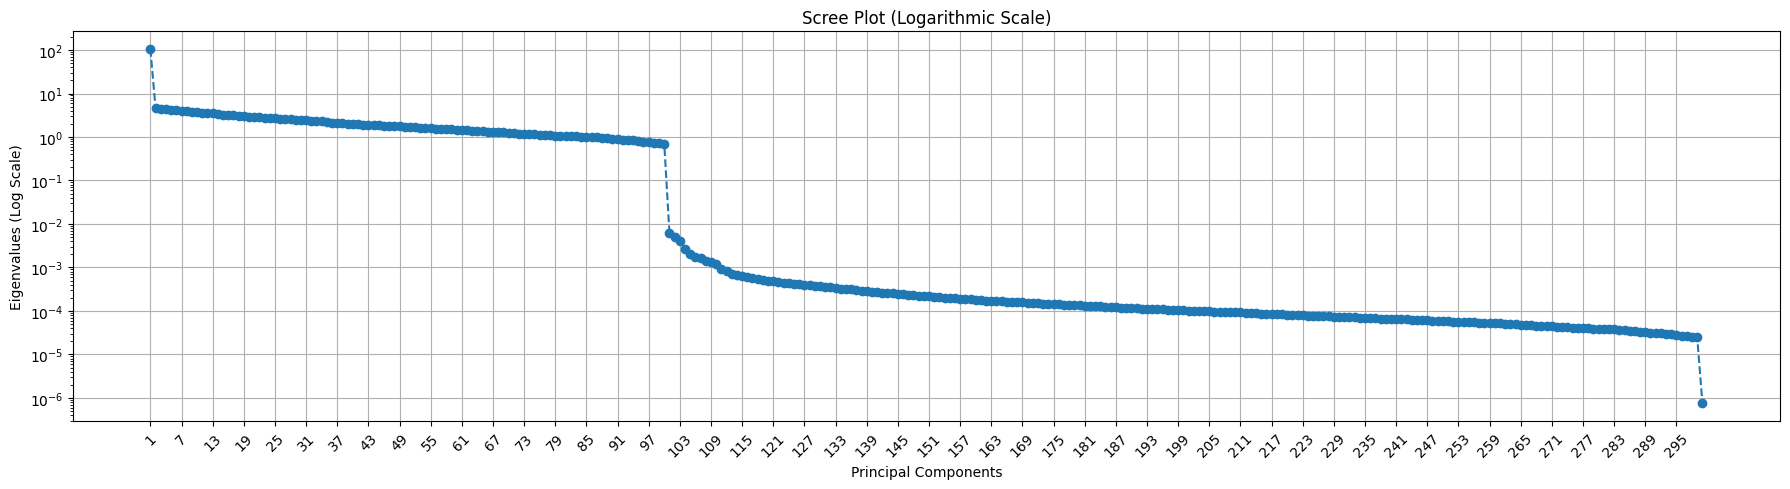

In [59]:
import PCA

Z, eigenvalues, reduced_space = PCA.PCA(
    dataset, 
    n_components=N
)

components = range(1, len(eigenvalues) + 1)

plt.figure(figsize=(18, 5))
plt.plot(components, eigenvalues, marker='o', linestyle='--')
plt.title('Scree Plot (Logarithmic Scale)')
plt.xlabel('Principal Components')
plt.ylabel('Eigenvalues (Log Scale)')
plt.yscale('log')

plt.xticks(components, rotation=45)

plt.xticks(components[::((N-1)//50)+1])

plt.grid()
plt.tight_layout()
plt.show()


It is possible to derive the ID of the manifold by putting an acceptable threshold to the kept variance:

In [60]:
acceptable_threshold = 0.999

_, eigenvalues_thresh, _ = PCA.PCA(
    dataset,
    spectrum_percentage=acceptable_threshold
)

d_pca = len(eigenvalues_thresh)
print(f'{acceptable_threshold*100}% of the variance is held in the first {d_pca} eigenvalues.')

99.9% of the variance is held in the first 100 eigenvalues.


### **twoNN**

**twoNN** is a local geometric ID estimator based on the assumption that density is constant between the two closest neighbors:
$$\mu_i = \frac{r^i_2}{r^i_1} \quad\quad p(\mu) = \mu^{-d-1} \times d$$
One can then find d through the slope of the log plot of the $\mu$ values:

In [61]:
import twoNN

d_twonn, mu_values = twoNN.two_nn(
    dataset,
    trim=0.002
)

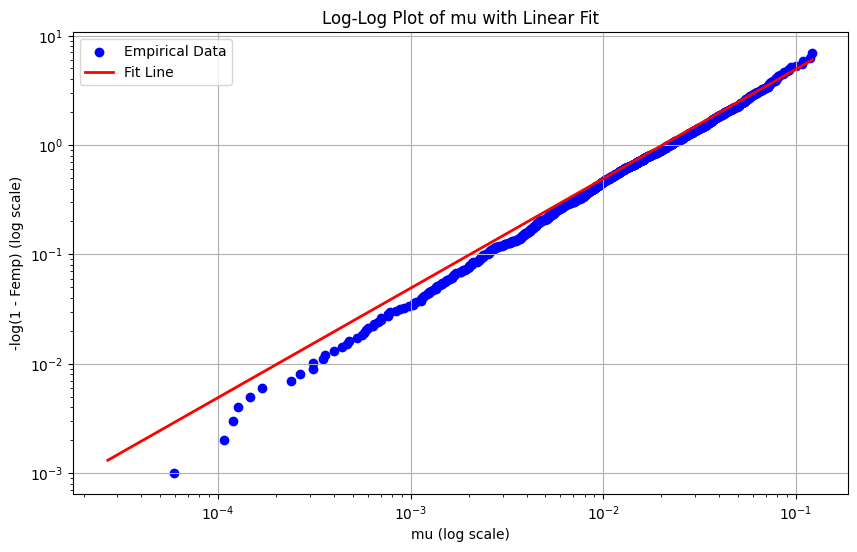

47.68470053060847


In [62]:
from sklearn.linear_model import LinearRegression

# Assuming mu_values and Femp are already defined
N_plot = len(mu_values)
Femp = np.arange(N_plot) / N_plot

# Create the plot
plt.figure(figsize=(10, 6))

# Scatter plot of log(mu_values) vs -log(1 - Femp)
plt.scatter(np.log(mu_values), -np.log(1 - Femp), label='Empirical Data', color='blue', marker='o')

# Fit line using linear regression in log-log space
log_mu_values = np.log(mu_values).reshape(-1, 1)
log_Femp = -np.log(1 - Femp).reshape(-1, 1)

Ir = LinearRegression(fit_intercept=True)
Ir.fit(log_mu_values, log_Femp)

# Calculate the predicted values
log_Femp_pred = Ir.predict(log_mu_values)

# Plot the fit line
plt.plot(np.log(mu_values), np.log(mu_values)*Ir.coef_[0][0], color='red', label='Fit Line', linewidth=2)

# Set both axes to logarithmic scale
plt.xscale('log')
plt.yscale('log')

# Labels and title
plt.xlabel('mu (log scale)')
plt.ylabel('-log(1 - Femp) (log scale)')
plt.title('Log-Log Plot of mu with Linear Fit')
plt.legend()
plt.grid()
plt.show()

print(d_twonn)

## **Full Correlation Integral**

In order to push through the problem with undersampling and the curse of dimensionality, extra assumptions about the data have to be made.
More specifically, FCI makes an extra assumption about the distribution: **the data is isotropic**:
$$||x|| = 1 \quad \forall x$$
This means the algorithm is working on a n-1 hypersphere surface of the original n-dimensional embedding space of the dataset.

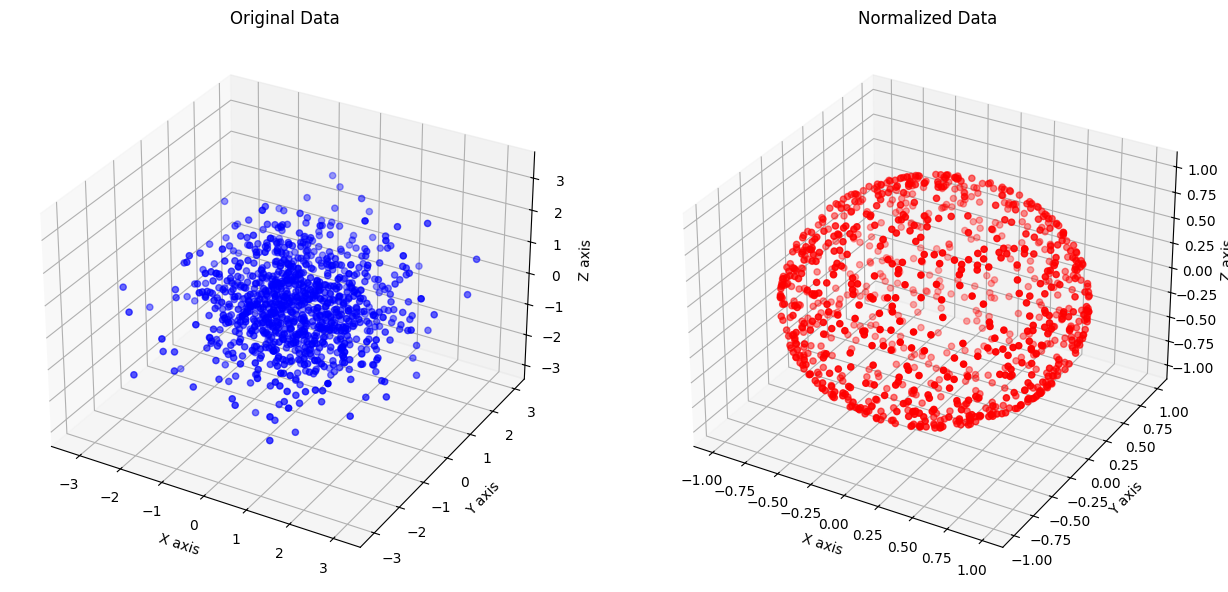

In [63]:
import FCI

fig = plt.figure(figsize=(13, 6))

sphere_data = dataset_generator.generate_gaussian_dataset(
    dimension=3,
    intrinsic=3,
    samples=1000,
    noise=0.001,
    influence=0.0
)

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(sphere_data[:, 0], sphere_data[:, 1], sphere_data[:, 2], c='b', marker='o')
ax1.set_title('Original Data')
ax1.set_xlabel('X axis')
ax1.set_ylabel('Y axis')
ax1.set_zlabel('Z axis')

normalized_sphere_data = FCI.center_and_normalize(sphere_data)
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(normalized_sphere_data[:, 0], normalized_sphere_data[:, 1], normalized_sphere_data[:, 2], c='r', marker='o')
ax2.set_title('Normalized Data')
ax2.set_xlabel('X axis')
ax2.set_ylabel('Y axis')
ax2.set_zlabel('Z axis')

plt.tight_layout()
plt.show()

The average correlation integral for the n-1 hypersphere can be analytically evaluated as:
$$\overline{\rho_S(\bar{r})} = \frac{1}{2} + \frac{\Omega_{d-1}}{2\Omega_d} \, {}_2F_1\left( \frac{1}{2}, 1 - \frac{d}{2}; \frac{3}{2} \, \bigg| \, \bigg| \, (\bar{r}^2 - 2)^2 \right)$$

One can then:
- Center and normalize the original data.
- Measure the empirical correlation integral of the dataset as a function of the radius r and perform a non-linear regression of this empirical density of neighbours using the FCI as the non-linear model and d and $r_s$ as the free parameters.

In [64]:
normalized_dataset = FCI.center_and_normalize(dataset)

rs = FCI.FCI(normalized_dataset)
d_fci, _, mse_fci = FCI.fit_FCI(rs)
print(d_fci)

99.06886684354203


It is also possible to calculate the FCI of a local neighborhood of a point (either a certain radius or k-nearest neighbors), which does give information about the local ID of a specific point:

In [ ]:
swiss_roll = sklearn.datasets.make_swiss_roll(n_samples=samples)[0]

# Local estimate for Swiss Roll (15 neighboring points)
d_fci_swiss_local, _, mse_fci_swiss_local = FCI.local_FCI(
    dataset=swiss_roll, 
    center=0, 
    neighbours=15
)

print(f'The local dimension of the Swiss Roll is: {d_fci_swiss_local}')

# Global estimate for Swiss Roll (entire dataset)

d_fci_swiss_global, _, mse_fci_swiss_global = FCI.local_FCI(
    dataset=swiss_roll,
    center=0,
    neighbours=samples
)

print(f'The global dimension of the Swiss Roll is: {d_fci_swiss_global}')

The local dimension of the Swiss Roll is: 2.728628455005559
The global dimension of the Swiss Roll is: 2.931409921585219


## Comparison

In [ ]:
d_list_PCA = []
d_list_twoNN = []
d_list_FCI = []

dataset_sizes = [10, 20, 30, 50, 75, 100, 200, 300, 400, 500, 750, 1000]
N = 300
d = 100
noise = 0.0025
influence = 1.0/d

for size in dataset_sizes:
    print(f'Calculating dataset with {size} samples...')
    dataset = dataset_generator.generate_gaussian_dataset(
        dimension=N,
        intrinsic=d,
        samples=size,
        noise=noise,
        influence=influence
    )
    d_list_PCA.append(len(PCA.PCA(dataset=dataset,spectrum_percentage=0.999)[1]))
    d_list_twoNN.append(float(twoNN.two_nn(dataset, trim=0.002)[0]))
    d_list_FCI.append(float(FCI.fit_FCI(FCI.FCI(FCI.center_and_normalize(dataset)),threshold=0.15)[0]))

fig, axs = plt.subplots(2, 1, figsize=(12, 12))

axs[0].plot(dataset_sizes, d_list_PCA, marker='o', label='PCA', color='blue')
axs[0].plot(dataset_sizes, d_list_twoNN, marker='s', label='TwoNN', color='orange')
axs[0].plot(dataset_sizes, d_list_FCI, marker='^', label='FCI', color='green')
axs[0].axhline(y=d, color='red', linestyle='--', label='Intrinsic Dimension (d)')
axs[0].set_xlabel('Dataset Size')
axs[0].set_ylabel('Estimated Dimension')
axs[0].set_title('Estimated Dimensions vs Dataset Size (Linear Scale)')
axs[0].legend()
axs[0].grid()

axs[1].plot(dataset_sizes, d_list_PCA, marker='o', label='PCA', color='blue')
axs[1].plot(dataset_sizes, d_list_twoNN, marker='s', label='TwoNN', color='orange')
axs[1].plot(dataset_sizes, d_list_FCI, marker='^', label='FCI', color='green')
axs[1].axhline(y=d, color='red', linestyle='--', label='Intrinsic Dimension (d)')
axs[1].set_xscale('log')
axs[1].set_xlabel('Dataset Size (log scale)')
axs[1].set_ylabel('Estimated Dimension')
axs[1].set_title('Estimated Dimensions vs Dataset Size (Logarithmic Scale)')
axs[1].legend()
axs[1].grid()

plt.tight_layout()

plt.show()


Calculating dataset with 10 samples...
Calculating dataset with 20 samples...
Calculating dataset with 30 samples...
Calculating dataset with 50 samples...
Calculating dataset with 75 samples...
Calculating dataset with 100 samples...
Calculating dataset with 200 samples...
Calculating dataset with 300 samples...
Calculating dataset with 400 samples...
Calculating dataset with 500 samples...
Calculating dataset with 750 samples...
Calculating dataset with 1000 samples...
